In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

(760, 1280, 3)


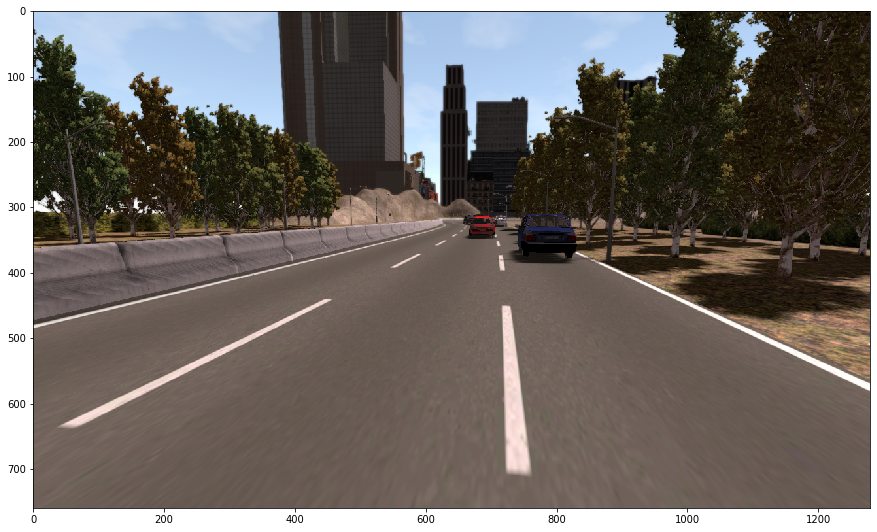

In [2]:
# load image 001109.png and show
img = cv2.imread('data/input/001109.png')
img_h, img_w, _ = img.shape
print(img.shape)

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

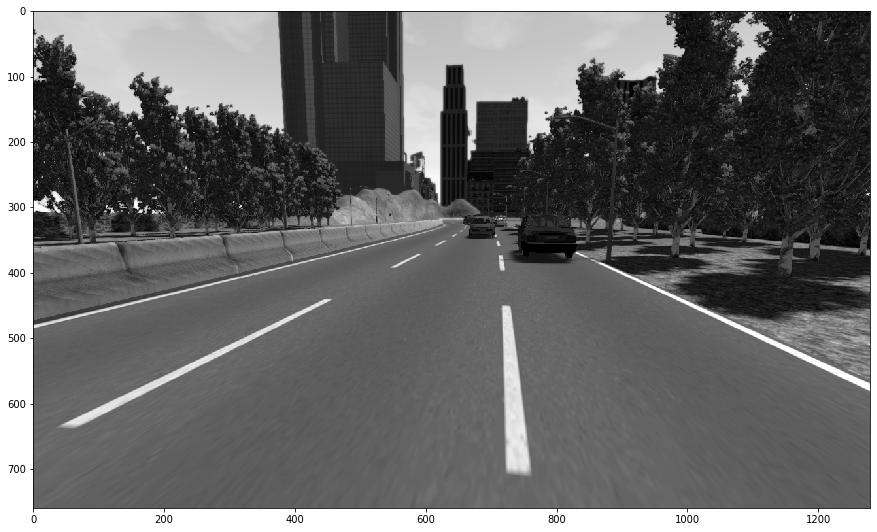

In [3]:
# convert to gray scale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 15))
plt.imshow(img_gray, cmap='gray', vmin=0, vmax=255)
plt.show()

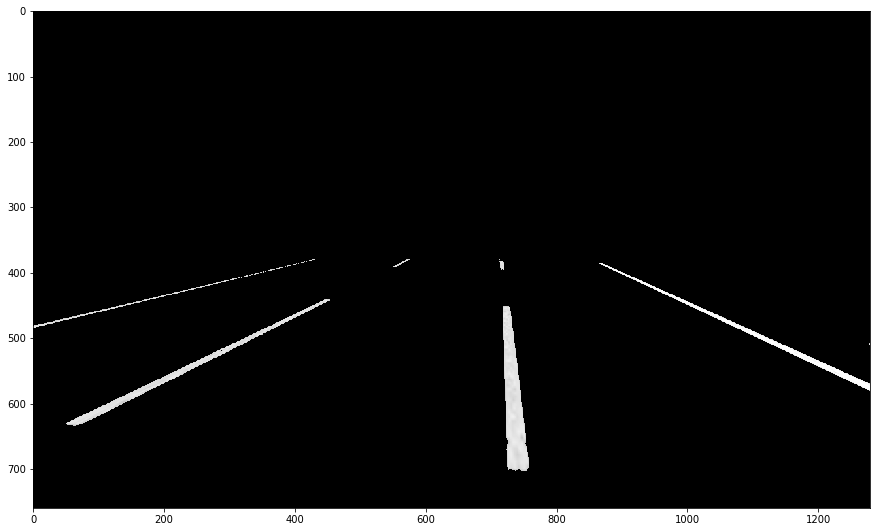

In [4]:
# filter by gray value and region
mask_color = cv2.inRange(img_gray, 200, 255)
# TODO refine mask_region, according to perspertive
mask_region = np.zeros((img_h, img_w), dtype=np.uint8)
seperate_line = img_h // 2  # set region of interest to lower part of image
mask_region[seperate_line:, : ] = 255
mask = cv2.bitwise_and(mask_color, mask_region)

img_mask = cv2.bitwise_and(img_gray, mask)

plt.figure(figsize=(15, 15))
plt.imshow(img_mask, cmap='gray', vmin=0, vmax=255)
plt.show()

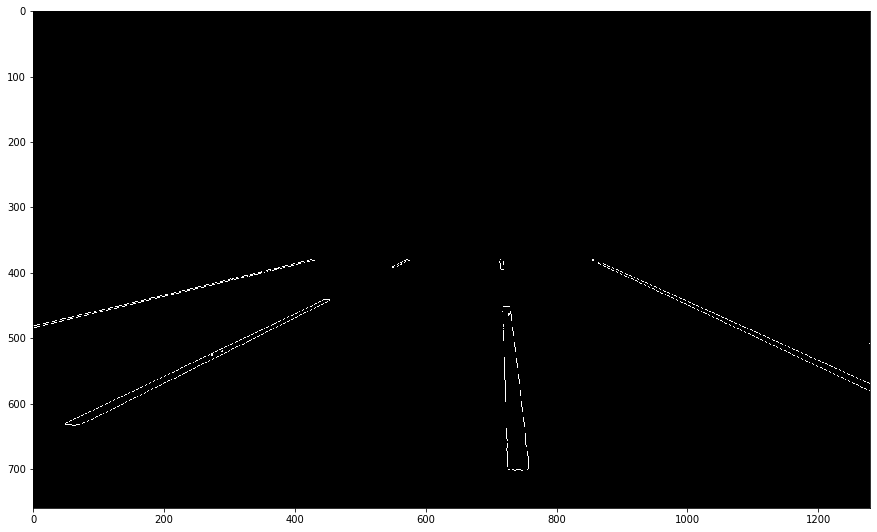

In [5]:
# canny edge detection
low_threshold = 50
high_threshold = 150
canny_edges = cv2.Canny(img_mask, low_threshold, high_threshold)

plt.figure(figsize=(15, 15))
plt.imshow(canny_edges, cmap='gray', vmin=0, vmax=255)
plt.show()

In [6]:
# extract points
x, y = np.where(canny_edges == 255)
kpts = np.vstack([x, y]).T


# set hough transform params
theta_max = 180
theta_step = 3

In [7]:
# use kpts to calculate rho for different theta
def get_rho(kpts: np.ndarray, theta_max, theta_step=1):
    """

    Args:
        kpts: dimension: n * 2
        theta_max:
        theta_step:

    Returns:

    """
    thetas = np.arange(0, theta_max, theta_step)
    cos_thetas = np.cos(np.radians(thetas))
    sin_thetas = np.sin(np.radians(thetas))

    mat_transform = np.vstack([cos_thetas, sin_thetas])

    rhos = np.dot(kpts, mat_transform)

    return rhos

In [8]:
rhos = get_rho(kpts, theta_max)

In [9]:
# 
def get_rho_theta_stat(theta_max, rhos):
    """
    
    Args:
        theta_max: 
        rhos: 

    Returns:

    """
    rho_min = int(np.min(rhos))
    rho_max = int(np.max(rhos))
    rho_theta_stat = np.zeros((rho_max - rho_min + 1, theta_max))
    rhos_h, rhos_w = rhos.shape
    for idx_col in range(rhos_w):
        for idx_row in range(rhos_h):
            rho_idx = int(rhos[idx_row, idx_col]) - rho_min
            rho_theta_stat[rho_idx, idx_col] += 1

    return rho_theta_stat, rho_min

In [10]:
rho_theta_stat, rho_min = get_rho_theta_stat(theta_max, rhos)

In [11]:
def get_n_lines(rho_theta_stat, rho_min, theta_max, nb_line):
    lines = []
    for i in range(nb_line):
        tmp_idx = np.argmax(rho_theta_stat)
        idx_row = tmp_idx // theta_max
        idx_col = tmp_idx % theta_max
        lines.append((idx_row + rho_min, idx_col))
        print((idx_row + rho_min, idx_col))
        print("Nb voting: ", rho_theta_stat[idx_row, idx_col])
        rho_theta_stat[idx_row, idx_col] = -1

    lines = np.array(lines)
    return lines

In [12]:
nb_line = 20 # nb of lines wanted to show
lines = get_n_lines(rho_theta_stat, rho_min, theta_max, nb_line)

(15, 155)
Nb voting:  260.0
(468, 13)
Nb voting:  258.0
(1, 156)
Nb voting:  218.0
(470, 14)
Nb voting:  213.0
(668, 97)
Nb voting:  183.0
(701, 92)
Nb voting:  173.0
(471, 14)
Nb voting:  166.0
(467, 13)
Nb voting:  162.0
(0, 156)
Nb voting:  161.0
(469, 14)
Nb voting:  149.0
(598, 27)
Nb voting:  126.0
(597, 27)
Nb voting:  124.0
(589, 26)
Nb voting:  119.0
(598, 26)
Nb voting:  119.0
(469, 13)
Nb voting:  116.0
(599, 27)
Nb voting:  115.0
(470, 13)
Nb voting:  108.0
(590, 26)
Nb voting:  106.0
(588, 25)
Nb voting:  105.0
(589, 25)
Nb voting:  105.0


In [13]:
def get_rho_theta_to_xy(lines, img_shape):
    xy_corrdinates = []
    (img_h, img_w) = img_shape
    for i in range(lines.shape[0]):
        tmp = []
        cnt = 0
        if lines[i, 1] == 0:
            x0 = 0
            y0 = lines[i, 0]
            x1 = img_h
            y1 = lines[i, 0]
            xy_corrdinates.append(((int(x0), int(y0)), (int(x1), int(y1))))
            continue
        elif lines[i, 1] == 90:
            y0 = 0
            x0 = lines[i, 0]
            y1 = img_w
            x1 = lines[i, 0]
            xy_corrdinates.append(((int(x0), int(y0)), (int(x1), int(y1))))
            continue
        else:
            x = 0
            y = lines[i, 0] / np.sin(np.radians(lines[i, 1]))
            if 0 <= y <= img_w:
                tmp.append((int(x), int(y)))
                cnt += 1
            if cnt >= 2:
                xy_corrdinates.append(tmp)
                continue

            x = img_h
            y = (lines[i, 0] - x * np.cos(np.radians(lines[i, 1]))) / np.sin(np.radians(lines[i, 1]))
            if 0 <= y <= img_w:
                tmp.append((int(x), int(y)))
                cnt += 1
            if cnt >= 2:
                xy_corrdinates.append(tmp)
                continue

            y = 0
            x = lines[i, 0] / np.cos(np.radians(lines[i, 1]))
            if 0 <= x <= img_h:
                tmp.append((int(x), int(y)))
                cnt += 1
            if cnt >= 2:
                xy_corrdinates.append(tmp)
                continue

            y = img_h
            x = (lines[i, 0] - y * np.sin(np.radians(lines[i, 1]))) / np.cos(np.radians(lines[i, 1]))
            if 0 <= x <= img_h:
                tmp.append((int(x), int(y)))
                cnt += 1
            if cnt >= 2:
                xy_corrdinates.append(tmp)
                continue

    return xy_corrdinates

In [14]:
xy_coordinates = get_rho_theta_to_xy(lines, (img_h, img_w))

In [15]:
xy_coordinates

[[(0, 35), (337, 760)],
 [(480, 0), (304, 760)],
 [(0, 2), (337, 760)],
 [(484, 0), (294, 760)],
 [(0, 673), (760, 766)],
 [(0, 701), (760, 727)],
 [(485, 0), (295, 760)],
 [(479, 0), (303, 760)],
 [(0, 0), (0, 0)],
 [(483, 0), (293, 760)],
 [(671, 0), (283, 760)],
 [(670, 0), (282, 760)],
 [(655, 0), (284, 760)],
 [(665, 0), (294, 760)],
 [(481, 0), (305, 760)],
 [(672, 0), (285, 760)],
 [(482, 0), (306, 760)],
 [(656, 0), (285, 760)],
 [(648, 0), (294, 760)],
 [(649, 0), (295, 760)]]

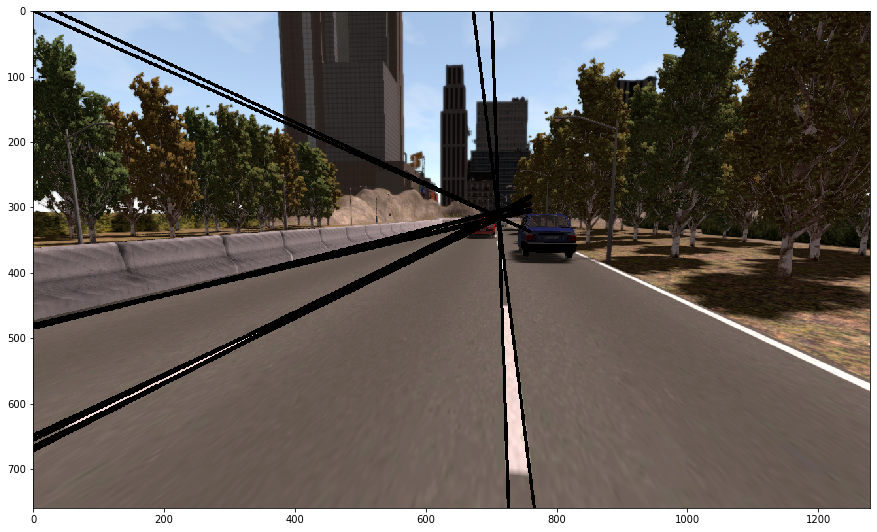

In [17]:
for xy in xy_coordinates:
    cv2.line(img, (xy[0][1], xy[0][0]), (xy[1][1], xy[1][0]), 0, thickness=3)

plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()